In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import logging

logger = logging.basicConfig(level=logging.INFO)

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = 12

## install dependencies

In [2]:
# !mamba install -c conda-forge -y proj-data sentinelsat xmlschema

In [3]:
# !pip install elevation sarsen xarray-sentinel

In [4]:
import os

import numpy as np
import rioxarray  # enable the `.rio` accessor
import xarray as xr

from sarsen import apps, scene

INFO:xmlschema:Resource 'XMLSchema.xsd' is already loaded


## processing definition

In [5]:
os.makedirs("data", exist_ok=True)
dem_urlpath = "data/Gran-Sasso-30m-DEM.tif"
dem_10m_UTM_urlpath = dem_urlpath.strip(".tif") + "_10m_UTM.tif"

product_folder = "GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371"
measurement_group = "IW/VV"

## download DEM

In [6]:
import elevation

In [7]:
! eio clip -o {dem_urlpath} --bounds 13.1 42. 13.95 42.75

make: Entering directory '/Users/amici/Library/Caches/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/Users/amici/Library/Caches/elevation/SRTM1'
make: Entering directory '/Users/amici/Library/Caches/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/Users/amici/Library/Caches/elevation/SRTM1'
make: Entering directory '/Users/amici/Library/Caches/elevation/SRTM1'
cp SRTM1.vrt SRTM1.7d738e0697d843b0a9f1e7e4b8266ec5.vrt
make: Leaving directory '/Users/amici/Library/Caches/elevation/SRTM1'
make: Entering directory '/Users/amici/Library/Caches/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 13.1 42.75 13.95 42.0 SRTM1.7d738e0697d843b0a9f1e7e4b8266ec5.vrt /Users/amici/devel/bopen/data/Gran-Sasso-30m-DEM.tif
rm -f SRTM1.7d738e0697d843b0a9f1e7e4b8266ec5.vrt
make: Leaving directory '/Users/amici/Library/Caches/elevation/SRTM1'


### RESAMPLING UTM DEM

#### 10 meters

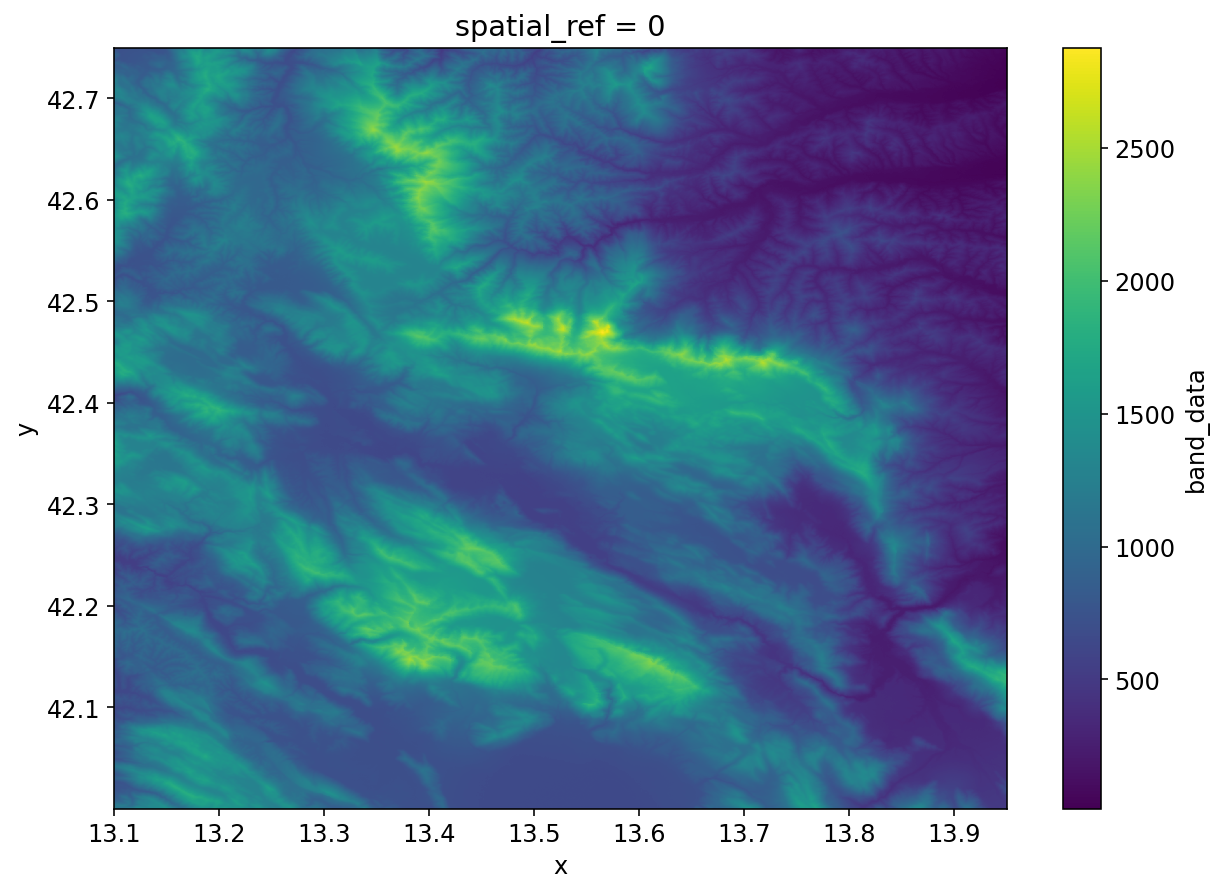

In [8]:
dem_raster = scene.open_dem_raster(dem_urlpath)
_ = dem_raster.plot()

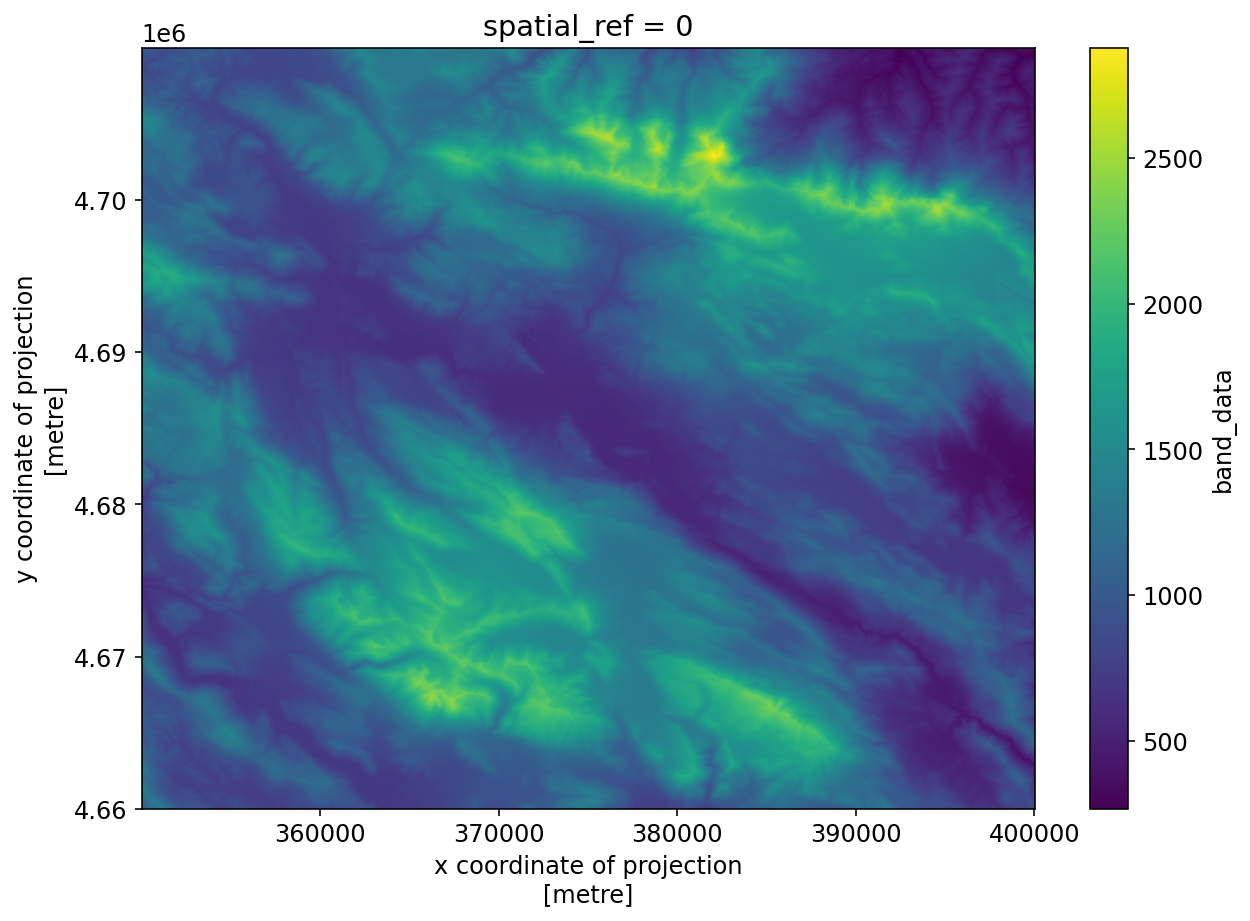

In [9]:
dem_UTM_corners = dict(x=slice(350000, 400000), y=slice(4710000, 4660000))

resolution = (10, 10)

t_srs = dem_raster.rio.estimate_utm_crs()
dem_raster_10m_UTM = dem_raster.rio.reproject(t_srs, resolution=resolution)

dem_raster_10m_UTM = dem_raster_10m_UTM.sel(**dem_UTM_corners)

dem_raster_10m_UTM.rio.to_raster(dem_10m_UTM_urlpath)
dem_raster_10m_UTM.plot();

## download data

In [10]:
import os

import adlfs
import planetary_computer
import pystac_client
import stackstac


def mirror_folder(fs, bucket, folder, exclude="vh"):
    for path, folders, files in fs.walk(f"{bucket}/{folder}"):
        os.makedirs(path[len(bucket) + 1 :], exist_ok=True)
        for f in files:
            if exclude in f:
                continue
            file_path = os.path.join(path, f)
            lfile_path = file_path[len(bucket) + 1 :]
            if not os.path.isfile(lfile_path):
                print(file_path)
                fs.download(file_path, lfile_path + "~")
                os.rename(lfile_path + "~", lfile_path)

In [11]:
grd_account_name = "sentinel1euwest"
grd_bucket = "s1-grd"
grd_token = planetary_computer.sas.get_token(grd_account_name, grd_bucket).token

grd_product_folder = f"{grd_bucket}/{product_folder}"

grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(grd_product_folder)

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd?restype=REDACTED&comp=REDACTED&prefix=REDACTED&delimiter=REDACTED&include=REDACTED&st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': 'ebf26eca-a86a-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/xml'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '0297fd68-601e-0074-0477-3cd679000000'
    'x-ms-client-r

['s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/annotation',
 's1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/manifest.safe',
 's1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement',
 's1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/preview',
 's1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/productInfo.json',
 's1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/report-20211223T060659.pdf',
 's1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/support']

In [ ]:
mirror_folder(grd_fs, grd_bucket, product_folder)

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd?restype=REDACTED&comp=REDACTED&prefix=REDACTED&delimiter=REDACTED&include=REDACTED&st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': 'ec59cf48-a86a-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/xml'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '0297fe50-601e-0074-5077-3cd679000000'
    'x-ms-client-r

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200
Response headers:
    'Transfer-Encoding': 'chunked'
    'Content-Type': 'application/xml'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02980145-601e-0074-7a77-3cd679000000'
    'x-ms-client-request-id': 'ecc40f34-a86a-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:29:33 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-re

s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff


INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': 'fcb0bc12-a86a-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '0298a0c7-601e-0074-2a77-3cd679000000'
    'x-ms-client-request-id': '0676ac20-a86b-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:30:16 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '13ed72da-a86b-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02998b41-601e-0074-0b77-3cd679000000'
    'x-ms-client-request-id': '2880f5c8-a86b-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:31:13 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '38bf7fb8-a86b-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '029a5927-601e-0074-2378-3cd679000000'
    'x-ms-client-request-id': '44084ef4-a86b-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:31:59 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '5241ed9a-a86b-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '029b1b2e-601e-0074-7978-3cd679000000'
    'x-ms-client-request-id': '606e58a4-a86b-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:32:47 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '6dc67ee6-a86b-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '029bc0e8-601e-0074-2c78-3cd679000000'
    'x-ms-client-request-id': '788f6950-a86b-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:33:28 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': 'a2e16654-a86b-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '029ea2f0-601e-0074-2278-3cd679000000'
    'x-ms-client-request-id': 'e89d697c-a86b-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:36:36 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '29bdc5d2-a86c-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02a26e90-601e-0074-2a79-3cd679000000'
    'x-ms-client-request-id': '8184a916-a86c-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:40:52 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': 'b1b7c06e-a86c-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02a58db3-601e-0074-5779-3cd679000000'
    'x-ms-client-request-id': 'f2845594-a86c-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:44:01 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '6d968ac2-a86d-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02ab4e37-601e-0074-0a7a-3cd679000000'
    'x-ms-client-request-id': 'bc8d2b0e-a86d-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:49:40 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '3534564a-a86e-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02b05ca6-601e-0074-577b-3cd679000000'
    'x-ms-client-request-id': '7e143826-a86e-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 16:55:05 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': 'e8e52606-a86e-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02b57cbf-601e-0074-307c-3cd679000000'
    'x-ms-client-request-id': '453e7c18-a86f-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 17:00:39 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': 'a64c43aa-a86f-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'Last-Modified': 'Thu, 23 Dec 2021 07:19:42 GMT'
    'Accept-Ranges': 'REDACTED'
    'Etag': '"0x8D9C5E49711CA5D"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '02ba6c4f-601e-0074-0f7c-3cd679000000'
    'x-ms-client-request-id': 'f1ba9044-a86f-11ec-bde7-1679c2455ec5'
    'x-ms-version': 'REDACTED'
    'x-ms-creation-time': 'REDACTED'
    'x-ms-lease-status': 'REDACTED'
    'x-ms-lease-state': 'REDACTED'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-server-encrypted': 'REDACTED'
    'Date': 'Sun, 20 Mar 2022 17:05:29 GMT'
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.t

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2021/12/23/IW/DV/S1B_IW_GRDH_1SDV_20211223T051122_20211223T051147_030148_039993_5371/measurement/iw-vv.tiff?st=REDACTED&se=REDACTED&sp=REDACTED&sv=REDACTED&sr=REDACTED&skoid=REDACTED&sktid=REDACTED&skt=REDACTED&ske=REDACTED&sks=REDACTED&skv=REDACTED&sig=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-range': 'REDACTED'
    'If-Match': '"0x8D9C5E49711CA5D"'
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'x-ms-date': 'REDACTED'
    'x-ms-client-request-id': '54a63582-a870-11ec-bde7-1679c2455ec5'
    'User-Agent': 'azsdk-python-storage-blob/12.9.0 Python/3.9.10 (macOS-12.2.1-arm64-arm-64bit)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 206
Response headers:
    'Content-Length': '4194304'
    'Content-Type': 'application/octet-stream'
    'Content-Range': 'REDACTED'
    'La

In [ ]:
ds = xr.open_dataset(
    product_folder,
    engine="sentinel-1",
    group=measurement_group,
    # storage_options=storage_options,
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    chunks={"slant_range_time": 2048},
)
ds

In [ ]:
rtc_account_name = "sentinel1euwestrtc"
rtc_bucket = "sentinel1-grd-rtc"
rtc_token = planetary_computer.sas.get_token(rtc_account_name, rtc_bucket).token

rtc_product_folder = f"{rtc_bucket}/{product_folder}"

rtc_fs = adlfs.AzureBlobFileSystem(rtc_account_name, credential=rtc_token)
rtc_fs.ls(rtc_product_folder)

In [ ]:
mirror_folder(rtc_fs, rtc_bucket, product_folder)

## process

#### GTC

In [ ]:
gtc_path = os.path.basename(product_folder) + ".10m.GTC.tif"

apps.backward_geocode_sentinel1(
    product_folder,
    measurement_group,
    dem_10m_UTM_urlpath,
    interp_method="nearest",
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    chunks={"slant_range_time": 2048},
    output_urlpath=gtc_path,
)
gtc_path

In [ ]:
gtc = xr.open_dataarray(gtc_path).drop("band")
gtc.plot(vmax=0.5);

#### RTC

In [ ]:
rtc_gamma_10m_path = os.path.basename(product_folder) + ".10m.RTC.tif"

rtc_gamma_10m = apps.backward_geocode_sentinel1(
    product_folder,
    measurement_group,
    dem_10m_UTM_urlpath,
    interp_method="nearest",
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    correct_radiometry="gamma",
    output_urlpath=rtc_gamma_10m_path,
    grouping_area_factor=(6, 6),
)
rtc_gamma_10m_path

In [ ]:
rtc_gamma_10m = xr.open_dataarray(rtc_gamma_10m_path, cache=False).drop("band");

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))

gtc.plot(ax=axes[0], vmax=0.5)
axes[0].grid(c="red")

rtc_gamma_10m.plot(ax=axes[1], vmax=0.5)
axes[1].grid(c="red")